In [ ]:
import os
import random 

import pandas as pd 
import numpy as np 
from scipy.stats import kurtosis, skew 
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns
# Importing librarys to use on interactive graphs
import plotly.offline as plty
from plotly import tools
import plotly.express as px
import time
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import json # to convert json in df
from pandas import json_normalize # to normalize the json file
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
import xgboost as xgb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q "./gdrive/MyDrive/CMPE 255/train.csv.zip"



yes


In [ ]:

ydf_train=pd.read_csv('./train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
def json_read(df):
    df = pd.read_csv(df, converters={column: json.loads for column in columns},dtype={'fullVisitorId': 'str'}) 
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df 

In [ ]:
df = json_read("./train.csv")

In [ ]:
df.to_csv('255-df-format.csv')

In [ ]:
df_file = pd.read_csv('255-df-format.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,55) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df['totals.pageviews'].mode()

0    1
dtype: object

In [ ]:
columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
print("No. of variables with unique value: {}".format(len(columns_to_remove)))

No. of variables with unique value: 24


In [ ]:
for col in columns_to_remove:
    if set(['not available in demo dataset']) ==  set(df[col].unique()): continue
    print(col, df[col].dtypes, df[col].unique())

socialEngagementType object ['Not Socially Engaged']
totals.visits object ['1']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
trafficSource.isTrueDirect object [nan True]
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']


In [ ]:
df_1 = df.copy()

In [ ]:
df_1['totals.pageviews'].fillna(1, inplace=True) # mode of page views is 1
df_1['totals.newVisits'].fillna(0, inplace=True)
df_1['totals.bounces'].fillna(0, inplace=True) 
df_1["totals.transactionRevenue"].fillna(0.0, inplace=True)

In [ ]:
#Changing objects to int
df_1['totals.pageviews'] = df_1['totals.pageviews'].astype(int)
df_1['totals.newVisits'] = df_1['totals.newVisits'].astype(int)
df_1['totals.bounces'] = df_1['totals.bounces'].astype(int)
df_1["totals.transactionRevenue"] = df_1["totals.transactionRevenue"].astype(float)

In [ ]:
df_1['trafficSource.isTrueDirect'].fillna(False, inplace=True) 
df_1['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True


In [ ]:
columns = [col for col in df_1.columns if df_1[col].nunique() > 1]
df_1 = df_1[columns]

In [ ]:
# Removing columns with high null values 
df_1.drop(columns=['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
                'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath',
                 'trafficSource.keyword'], inplace = True)

In [ ]:
df_2 = df_1.copy()

In [ ]:
# Visit time
df_2['diff_visitId_time'] = df_2['visitId'] - df_2['visitStartTime']
df_2['diff_visitId_time'] = (df_2['diff_visitId_time'] != 0).astype(int)
del df_2['visitId']

In [ ]:
# Visit hour
df_2['formated_visitStartTime'] = df_2['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
df_2['formated_visitStartTime'] = pd.to_datetime(df_2['formated_visitStartTime'])
df_2['visit_hour'] = df_2['formated_visitStartTime'].apply(lambda x: x.hour)
 
del df_2['visitStartTime']
del df_2['formated_visitStartTime']

In [ ]:
# date
format_str = '%Y%m%d' 
df_2['formated_date'] = df_2['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df_2['month'] = df_2['formated_date'].apply(lambda x:x.month)
df_2['quarter_month'] = df_2['formated_date'].apply(lambda x:x.day//8)
df_2['day'] = df_2['formated_date'].apply(lambda x:x.day)
df_2['weekday'] = df_2['formated_date'].apply(lambda x:x.weekday())
 
del df_2['date']

In [ ]:
# total hits
df_2['totals.hits'] = df_2['totals.hits'].astype(int)
df_2['mean_hits_per_day'] = df_2.groupby(['day'])['totals.hits'].transform('mean')
del  df_2['day']

In [ ]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    df_2[col] = df_2[col].astype(float)

In [ ]:
# Removing unwanted id columns
df_2 = df_2.drop(['fullVisitorId','sessionId'], axis = 1)

In [ ]:
# Copy for Encoding categorical features
df_3 = df_2.copy()

In [ ]:
cat_cols = ["channelGrouping", "device.browser", 
             "device.operatingSystem", 'device.isMobile','device.deviceCategory',
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", 
             "trafficSource.campaign",
            "trafficSource.medium", 
             "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

In [ ]:
for col in cat_cols:
    # print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_3[col].values.astype('str')))
    df_3[col] = lbl.transform(list(df_3[col].values.astype('str')))

In [ ]:
num_cols = ["totals.hits", "totals.pageviews", 
            "visitNumber", 
            'totals.bounces',  'totals.newVisits']    

for col in num_cols:
    df_3[col] = df_3[col].astype(float)

In [ ]:
df_3['visit_hour_sin'] = np.sin(df_3.visit_hour*(2.*np.pi/24))
df_3['visit_hour_cos'] = np.cos(df_3.visit_hour*(2.*np.pi/24))
df_3['month_sin'] = np.sin((df_3.month-1)*(2.*np.pi/12))
df_3['month_cos'] = np.cos((df_3.month-1)*(2.*np.pi/12))

In [ ]:
df_3['weekday_sin'] = np.sin((df_3.weekday-1)*(2.*np.pi/7))
df_3['weekday_cos'] = np.cos((df_3.weekday-1)*(2.*np.pi/7))


In [ ]:
del df_3['month']
del df_3['visit_hour']

In [ ]:
del df_3['weekday']

In [ ]:
plt.rcParams["figure.figsize"] = (30,30)

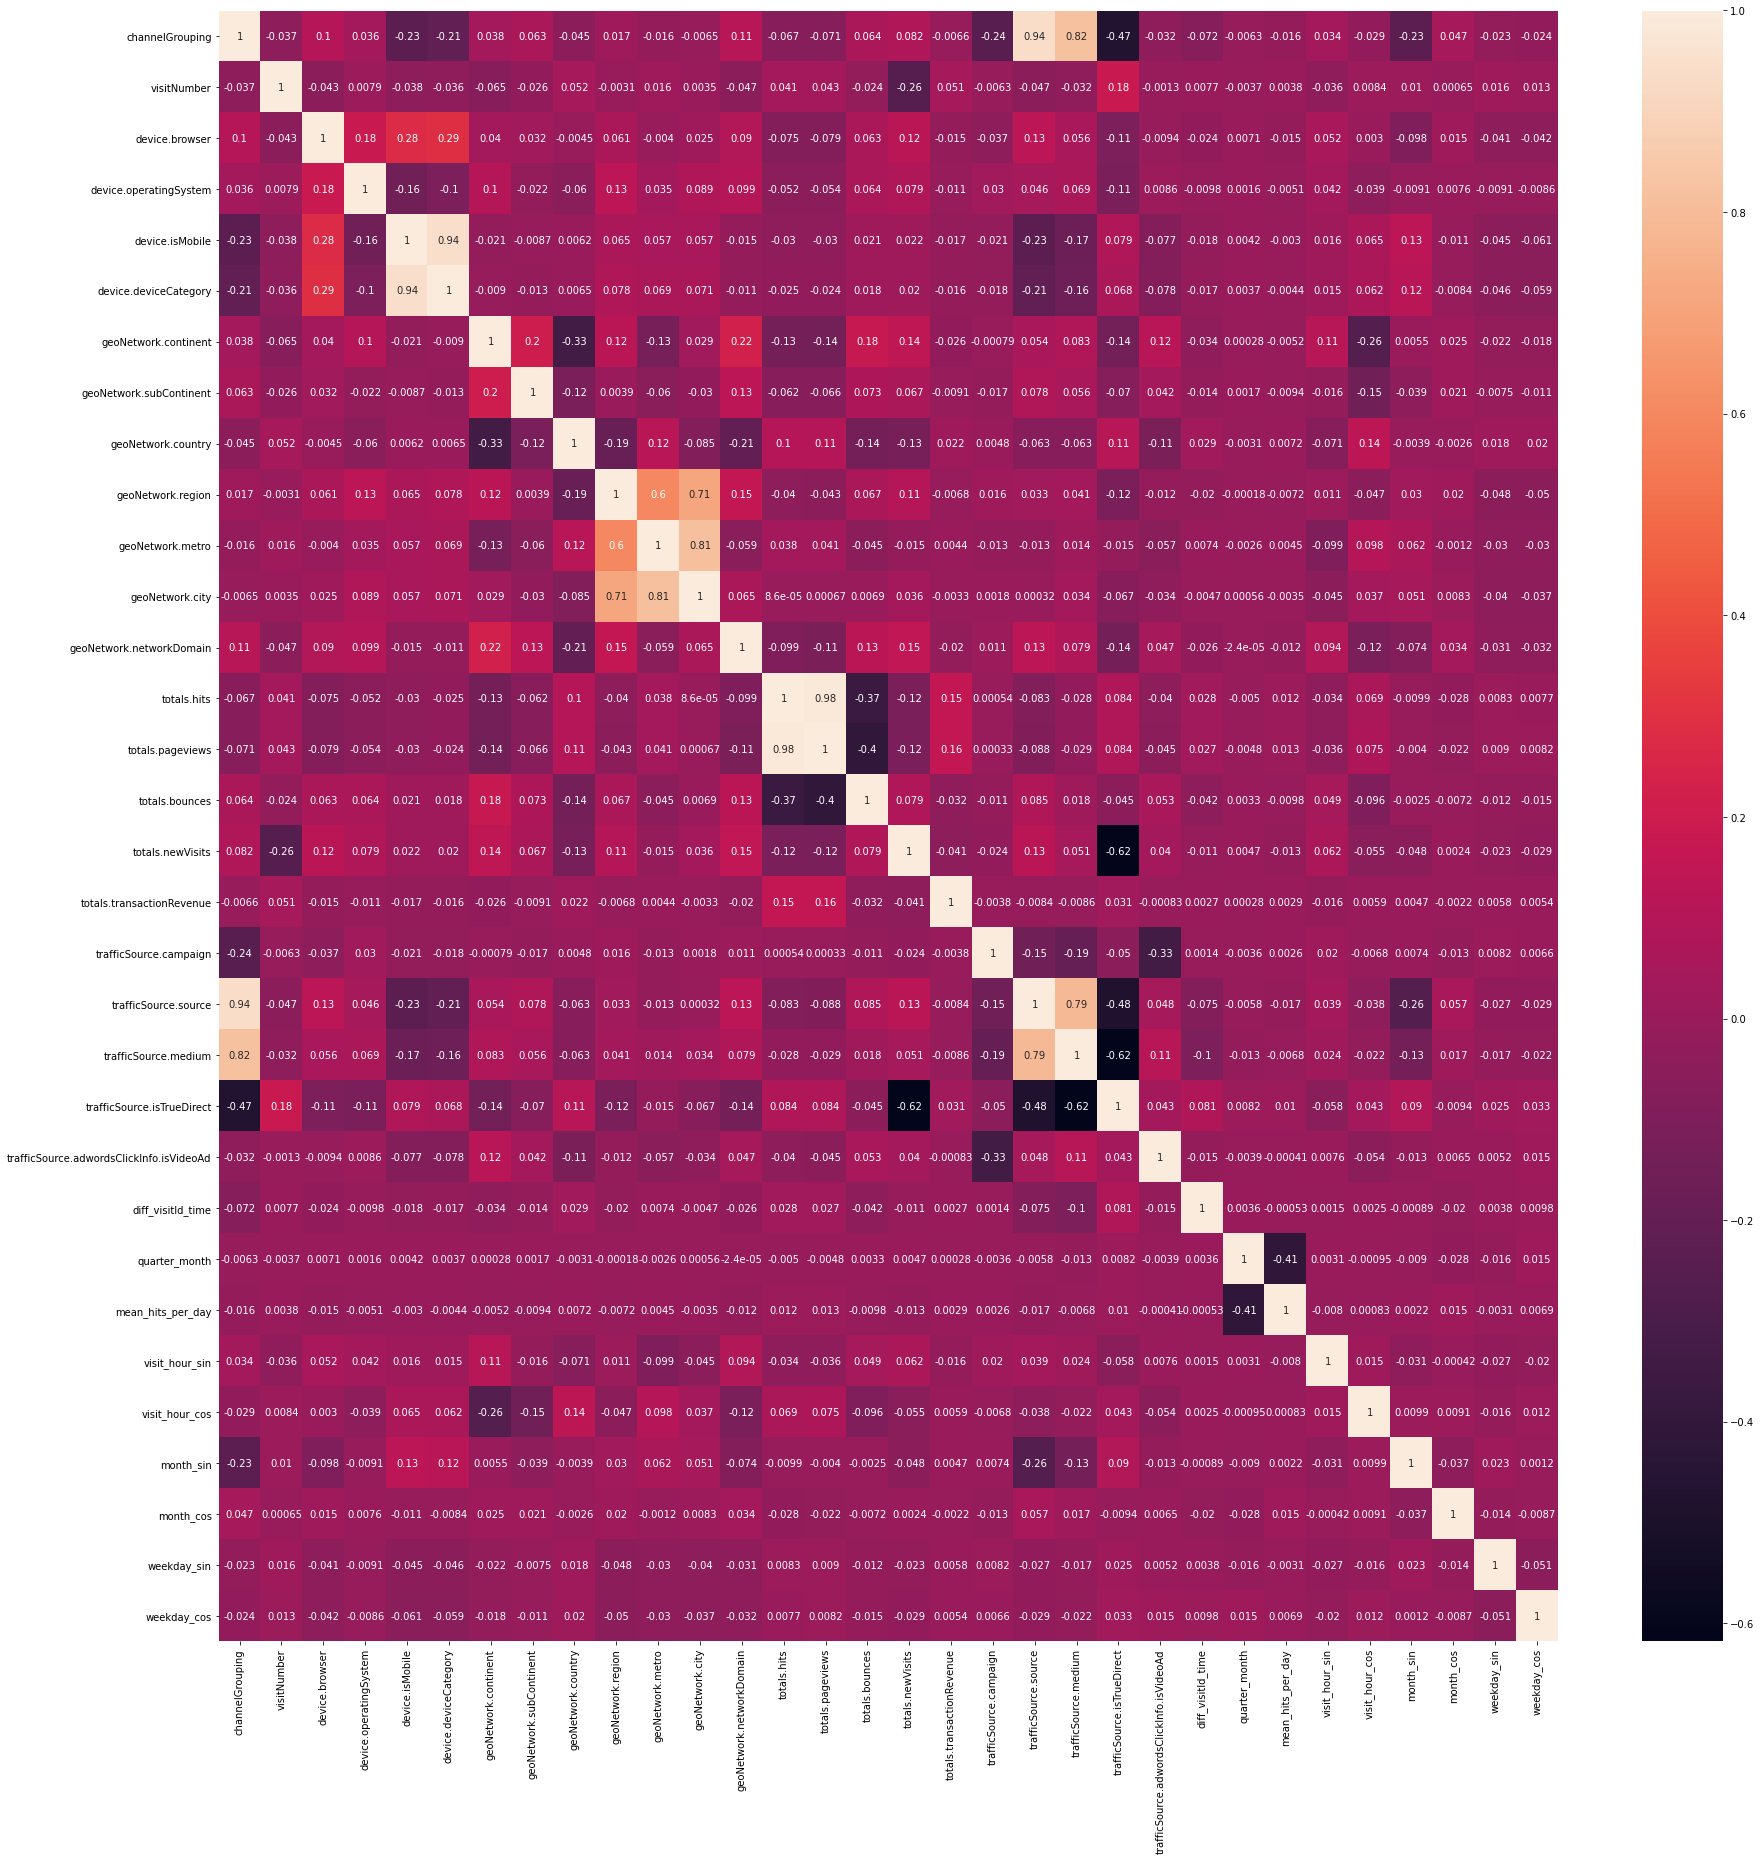

In [ ]:
sns.heatmap(df_3.corr(), annot = True)


In [ ]:
X = df_3.copy()

In [ ]:
from datetime import datetime, date

In [ ]:
X = X.set_index(X['formated_date'])
X = X.sort_index()

In [ ]:
min(X['formated_date'])

Timestamp('2016-08-01 00:00:00')

In [ ]:
max(X['formated_date'])

Timestamp('2017-08-01 00:00:00')

In [ ]:
train = X['2016-08-01':'2017-05-31']
test  = X['2017-05-31':]


In [ ]:
# Dropping date and target column
X_train = train.drop(['formated_date','totals.transactionRevenue'], axis = 1)
X_test = test.drop(['formated_date','totals.transactionRevenue'], axis=1)

In [ ]:
out = test['totals.transactionRevenue'].values

In [ ]:
output = pd.DataFrame(out)

In [ ]:
output.columns = ['ActualRevenue']

In [ ]:
#  transaction revenue
y_train = np.log1p(train["totals.transactionRevenue"].values)
y_test = np.log1p(test["totals.transactionRevenue"].values)

In [ ]:
output[(output['ActualRevenue'] > 0)].head()

,ActualRevenue
57,131310000.00
59,5601400000.00
63,71970000.00
64,31930000.00
66,417260000.00


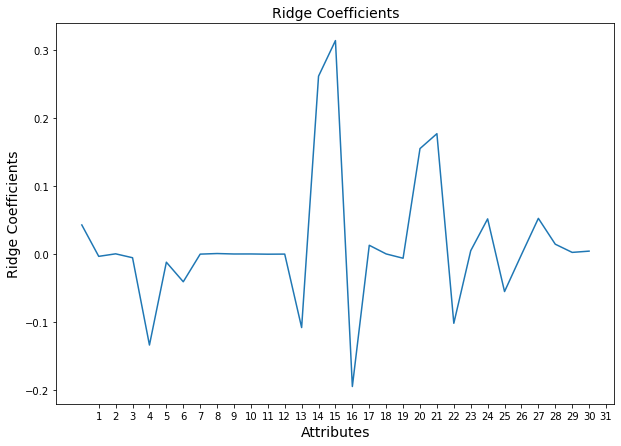

In [ ]:
from sklearn.linear_model import Ridge  
model = Ridge(alpha=0.01  )
pred=model.fit(X_train , y_train)
c= pred.coef_
ypred = model.predict(X_test)
pred.coef_.shape
plt.figure(figsize=(10,7)) 
plt.plot(range(31),c)
plt.xticks(range(1,32))
plt.ylabel('Ridge Coefficients',fontsize=14);
plt.xlabel('Attributes',fontsize=14)
plt.title('Ridge Coefficients',fontsize=14)
c= model.coef_


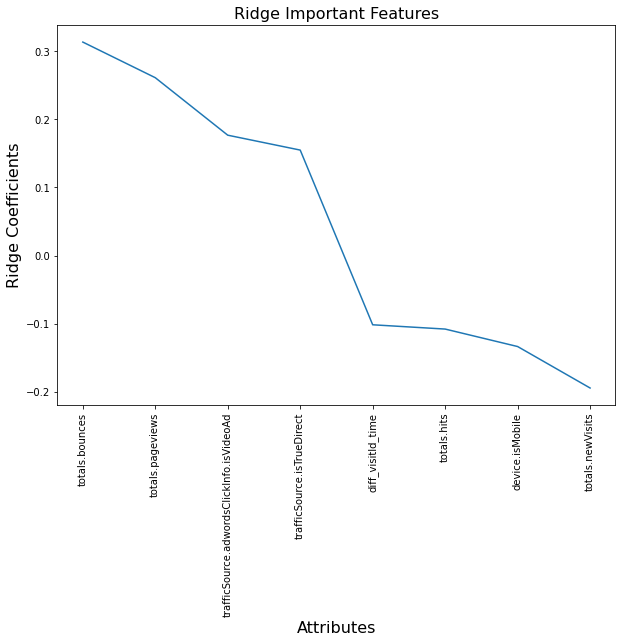

In [ ]:
Couple= [(X_train.columns[i], c[i] ) for i in range(len(c))] # List of (Attribute, Ridge_Coef)
Couple=sorted(Couple, key=lambda item: (item[1]),reverse=True)#Sorting attribute based on Ridge_Coef 
xlab=list() #Xlabel:List of Attributes
ylab=list() #Ylabel:List of Coef
for i in Couple:
  if abs(i[1])>0.1: #Filtering important attributes
    xlab.append(i[0]) 
    ylab.append(i[1])
plt.figure(figsize=(10,7)) 
plt.plot(range(8), ylab)
plt.xticks(range(8),xlab, fontsize=10, rotation='vertical')
plt.title('Ridge Important Features',fontsize=16)
plt.ylabel('Ridge Coefficients',fontsize=16)
plt.xlabel('Attributes', fontsize=16)
c= model.coef_


In [ ]:
print("The RMSE for the Ridge Model with alpha=0.01 is ", np.sqrt(metrics.mean_squared_error(y_test, ypred)))

The RMSE for the Ridge Model with alpha=0.01 is  1.9243107208196486


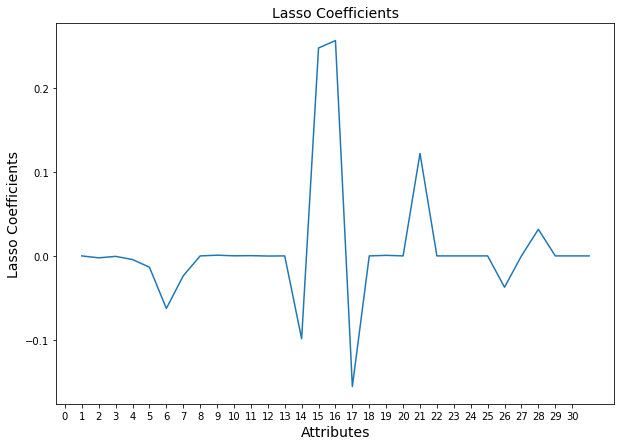

In [ ]:
from sklearn.linear_model import Lasso  
model = Lasso(alpha=0.01  )
pred=model.fit(X_train , y_train)
c= pred.coef_
ypred = model.predict(X_test)
pred.coef_.shape
plt.figure(figsize=(10,7)) 
plt.plot(range(1,32),c)
plt.xticks(range(31))
plt.title('Lasso Coefficients',fontsize=14)
plt.ylabel('Lasso Coefficients',fontsize=14)
plt.xlabel('Attributes', fontsize=14)
c= model.coef_


10


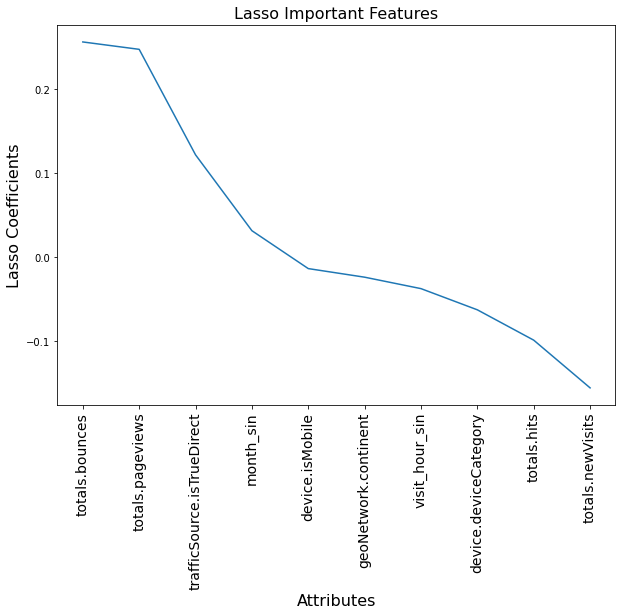

In [ ]:
Couple= [(X_train.columns[i], c[i] ) for i in range(len(c))] # List of (Attribute, Ridge_Coef)
Couple=sorted(Couple, key=lambda item: (item[1]),reverse=True)#Sorting attribute based on Ridge_Coef 
xlab=list() #Xlabel:List of Attributes
ylab=list() #Ylabel:List of Coef
for i in Couple:
  if abs(i[1])>0.01: #Filtering important attributes
    xlab.append(i[0]) 
    ylab.append(i[1])
print(len(xlab))

plt.figure(figsize=(10,7)) 
plt.plot(range(10), ylab)
plt.xticks(range(10),xlab, fontsize=14, rotation='vertical')
plt.title('Lasso Important Features',fontsize=16)
plt.ylabel('Lasso Coefficients',fontsize=16)
plt.xlabel('Attributes', fontsize=16)
c= model.coef_


In [ ]:
print("The RMSE for the Lasso Model with alpha=0.5 is ", np.sqrt(metrics.mean_squared_error(y_test, ypred)))

The RMSE for the Lasso Model with alpha=0.5 is  1.925298357613695


In [ ]:
df_1['Month'] =df_1['date'].map(str)
df_1['Month']=df_1['Month'].map(lambda x: (x[0:4]+"/"+x[4:6] if '/' not in x else x))
df_1['Day'] =df_1['date'].mod(100)

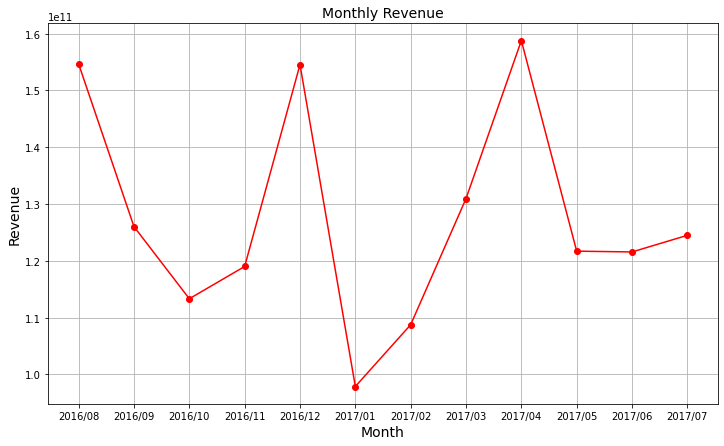

In [ ]:
df_R=df_1.copy()
groupeddf = df_R.groupby('Month')['totals.transactionRevenue'].sum().to_frame().reset_index()
groupeddf=groupeddf.iloc[:-1, :]
Month=groupeddf['Month']
Rev=groupeddf['totals.transactionRevenue']
plt.figure(figsize=(12,7)) 
plt.plot(Month, Rev, color='red', marker='o')

plt.title('Monthly Revenue', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
plt.grid(True)
plt.show()

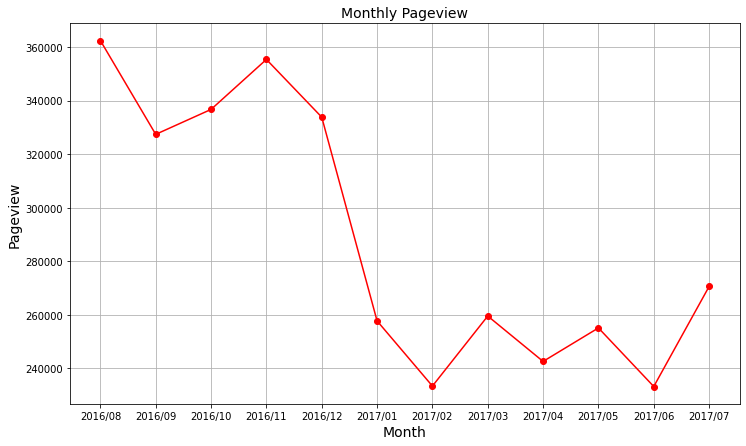

In [ ]:
groupeddf = df_R.groupby('Month')['totals.pageviews'].sum().to_frame().reset_index()
groupeddf=groupeddf.iloc[:-1, :]
Month=groupeddf['Month']
Rev=groupeddf['totals.pageviews']
plt.figure(figsize=(12,7)) 
plt.plot(Month, Rev, color='red', marker='o')

plt.title('Monthly Pageview', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pageview', fontsize=14)
plt.grid(True)
plt.show()